# Part 9: Vitis Accel

In the previous sections we've seen how to deploy a model on a [pynq-z2 board](http://www.pynq.io/) with the `VivadoAccelerator` backend. In this section, we introduce the `VitisAccelerator` backend of `hls4ml`, an alternative workflow for deploying models that uses AMD's Vitis Accel workflow. This time, we will deploy the model on an [Alveo U55C Accelerator Card](https://www.xilinx.com/products/boards-and-kits/alveo/u55c.html).

In [1]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)

2024-05-25 18:53:50.274166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load model
Load the model from `part4: quantization` (note that you need to have trained the model in part 4 first)

In [2]:
model = load_model('model_3/KERAS_check_best_model.h5', custom_objects=co)

2024-05-25 18:53:53.571794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Convert to hls4ml
Similar to part 7, We'll convert our model into `hls4ml`, targeting the `backend='VitisAccelerator'` backend this time around. This backend wraps the HLS model and adds a CPU/MCU program that drives the FPGA. We also specify `board='alveo-u55c'`.

In [3]:
import sys
import os

local_module_dir = os.path.join("/home/jovyan/work/hls4ml") # This should be changed the path of the local modified version of HLS4ML containing Vitis Accel backend
sys.path.insert(0, local_module_dir)

import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'

print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")

hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=config,
    output_dir='model_3/hls4ml_prj_vitis_accel',
    backend='VitisAccelerator',
    board='alveo-u55c',
    num_kernel=4,
    num_thread=8,
    batchsize=8192
)
hls_model.compile()

/home/jovyan/work/hls4ml/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Late

Done


Writing Accelerator code
Done


We can see which baords are supported in the [documentation](https://fastmachinelearning.org/hls4ml/advanced/accelerator.html). The `VitisAccelerator` backend has a different `AcceleratorConfig` section of the configuration. Here we can change some details of the Vitis Accel project.

In this example, we set `'num_kernel=4'`, directing Vitis Accel to create 4 copies of the kernel on the FPGA. We also set `'num_thread=8'`, meaning that the host code will create 8 threads to drive the FPGA. For a multi-core CPU, this improves throughput by increasing the speed at which data is written to the FPGA memory.

The `create_initial_config` method (of any backend) can be used to create a template dictionary with the default parameters that you can use as a starting point.

In [4]:
plotting.print_dict(hls4ml.backends.get_backend('VitisAccelerator').create_initial_config())

Part:                xcvu13p-flga2577-2-e
ClockPeriod:         5
IOType:              io_parallel
HLSConfig
AcceleratorConfig
  Board:             alveo-u55c
  Num_Kernel:        1
  Num_Thread:        1
  Batchsize:         8192


## Synthesize
As before, we'll run the 'build()' function. This time, it will launch the Vitis Accel flow, which first generates an IP with Vitis HLS, then runs Implementation with Vivado to create and package a bitstream that can be directly deployed onto an FPGA board. 

**This will take several hours.**

While Synthesis and Implementation is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_3/hls4ml_prj_vitis_accel/v++_myproject_kernel.log` during HLS \
and \
`tail -f model_1/hls4ml_prj/v++_kernel_wrapper.log` during implementation

In [5]:
# hls_model.build()

## Predict

With the Vitis Accelerator backend, in addition to running CPU emulation, we can run the model directly on the FPGA. We load the numpy arrays saved in Part 1, and check FPGA performance.

**Note: To use `hardware_predict()`, first ensure the .xclbin bitstream is generated in ./build**

Currently I do not have U55C FPGA and HLS4ML set-up in the same container, so I use a workaround. I manually copy tb_input_features.dat into the repo that's on my U55C project, run the host code, then copy hw_results.dat back out into the project folder here here.

`hls_model.hardware_predict(x_test)` should in theory abstract away this process.

In [6]:
import numpy as np

x_test = np.load("X_test.npy")
classes = np.load('classes.npy', allow_pickle=True)

y_actual = np.load("y_test.npy")
y_keras = model.predict(x_test)
# y_hls_hw = hls_model.hardware_predict(x_test) # Not used because I haven't figured out the set-up yet.

5188/5188 [==============================] - 12s 2ms/step


In [7]:
from hls4ml.backends.vitis_accelerator.vitis_accelerator_backend import VitisAcceleratorBackend

VitisAcceleratorBackend.numpy_to_dat(hls_model.config.backend, hls_model, x_test) # Manually copy tb_input_features.dat after executing this

In [8]:
y_hls_hw = VitisAcceleratorBackend.dat_to_numpy(hls_model.config.backend, hls_model) # Manually copy hw_results.dat before executing this

Keras  Accuracy: 0.7586686746987952
hls4ml hardware Accuracy: 0.7588132530120482


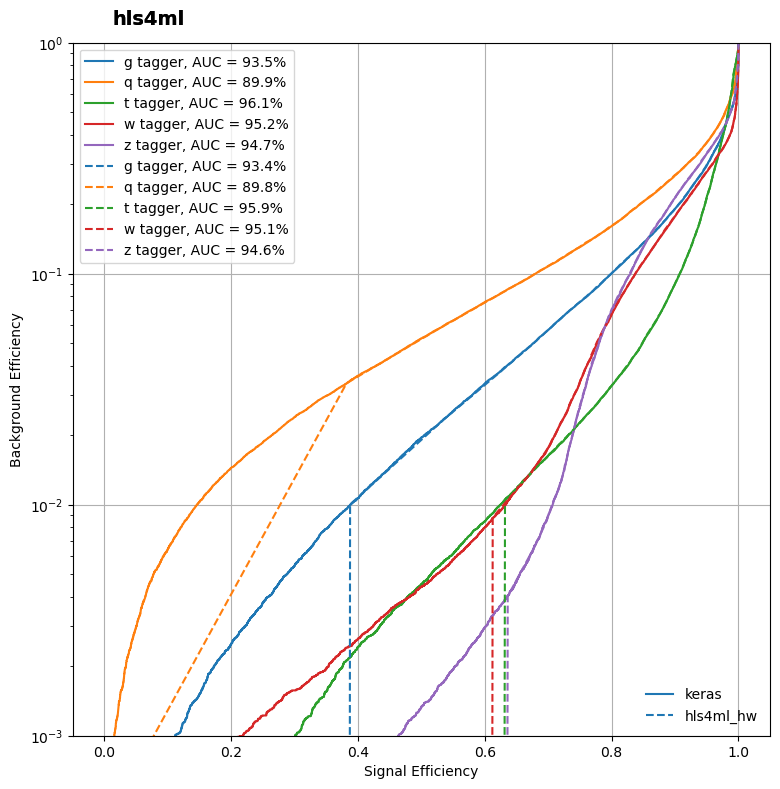

In [9]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_actual, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml hardware Accuracy: {}".format(accuracy_score(np.argmax(y_actual, axis=1), np.argmax(y_hls_hw, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_actual, y_keras, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_actual, y_hls_hw, classes, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml_hw'], loc='lower right', frameon=False)
ax.add_artist(leg)
